In [1]:
import torch
from inference_utils import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
args = Args(
    model_path="/ssd_scratch/cvit/kanishk/iros_checkpoints/talk2car/baseline_drop_0.25_bs_64_el_1_sl_40_bce_0.50473.pth",
    dataroot="/ssd_scratch/cvit/kanishk/Talk2Car-RefSeg/",
    glove_path="/ssd_scratch/cvit/kanishk/glove/",
    mask_thresh = 0.95
)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [5]:
val_loader = prepare_dataloader(args)

Initializing dataset


/home/kanishk/.pyenv/versions/3.8.5/envs/tracking/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
image_encoder, joint_model = prepare_network(args, n_gpu, device)

#### Sample a Random Example from Dataset

In [38]:
batch = get_random_sample(val_loader)

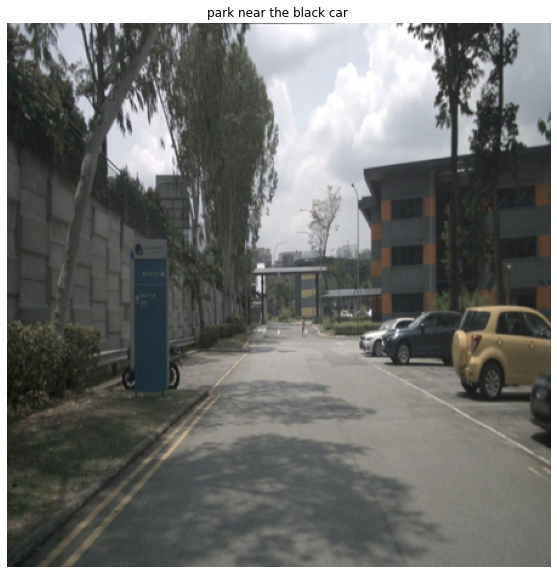

In [39]:
display_sample(batch)

In [40]:
original_phrase = modify_language_command(batch)

Use original command Y/N?: y


Command: park near the black car 


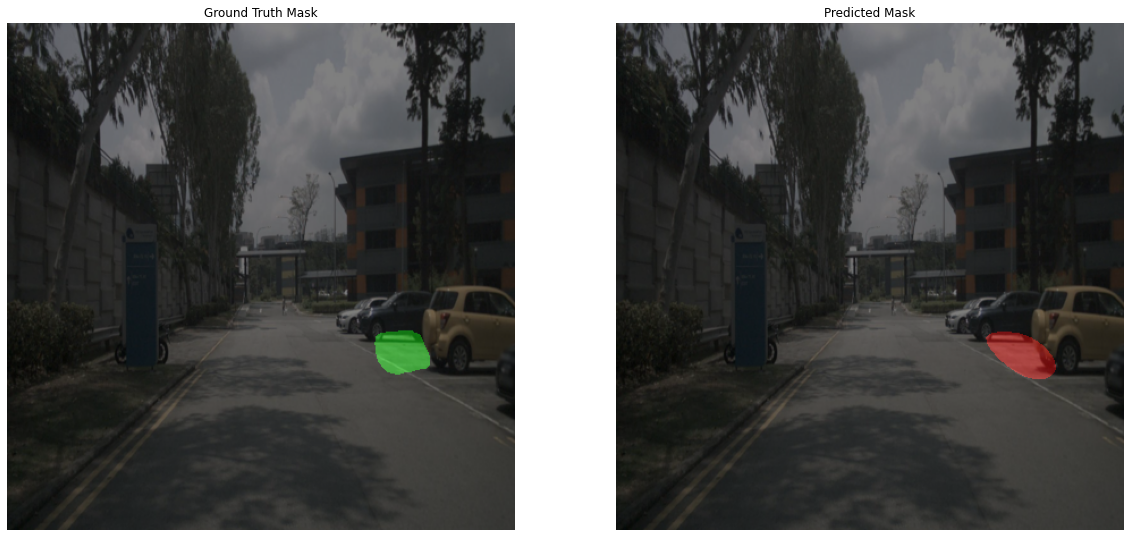

In [41]:
run_inference(batch, image_encoder, joint_model, val_loader, args, original_phrase)

Command: park near the black car 


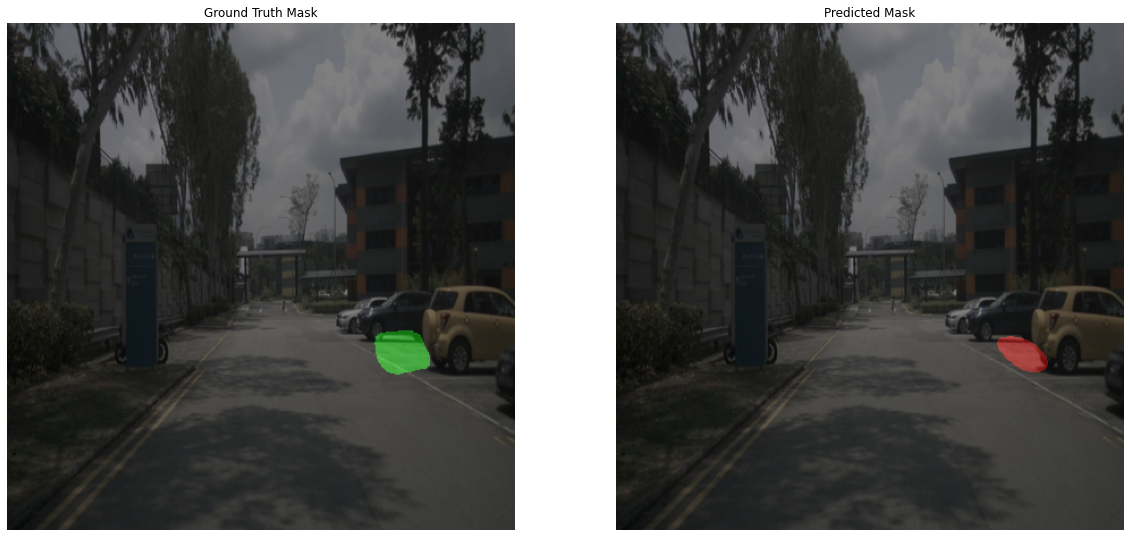

In [60]:
img = batch["image"].cuda(non_blocking=True).unsqueeze(0)
    
phrase, phrase_mask = val_loader.dataset.vocabulary.tokenize(batch["orig_phrase"])
# phrase, phrase_mask = val_loader.dataset.vocabulary.tokenize("take a left turn at the intersection")
phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

gt_mask = batch["seg_mask"]
gt_mask = gt_mask.squeeze(dim=1)

orig_image = batch["orig_image"]
orig_phrase = batch["orig_phrase"]

batch_size = img.shape[0]
img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

with torch.no_grad():
    img = image_encoder(img)  

output_mask = joint_model(img, phrase, img_mask, phrase_mask)

output_mask = output_mask.detach().cpu().squeeze()
mask_out = output_mask[0]

inter, union = compute_mask_IOU(output_mask, gt_mask)
score = inter / union

image = batch["orig_image"]
phrase = batch["orig_phrase"]
mask_gt = gt_mask
mask_pred = output_mask

im = image

if original_phrase:
    best_t = 0.4 # get_best_threshold(output_mask, gt_mask)
else:
    best_t = output_mask.mean()
    
## Prediction
im_seg = im[:] / 2
predicts = (mask_pred > best_t).numpy()
im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

## Ground Truth
im_gt = im[:] / 2
gt = (mask_gt > 0).numpy()
im_gt[:, :, 1] += gt.astype('uint8') * 100
im_gt = im_gt.astype('uint8')

print(f'Command: {phrase}')

if original_phrase:
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

    axes[0].imshow(im_gt)
    axes[0].set_title("Ground Truth Mask")
    axes[0].axis("off")

    axes[1].imshow(im_seg)
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

else:

    figure = plt.figure(figsize=(20, 20))

    plt.imshow(im_seg)
    plt.title("Predicted Mask")
    plt.axis('off')

plt.show()

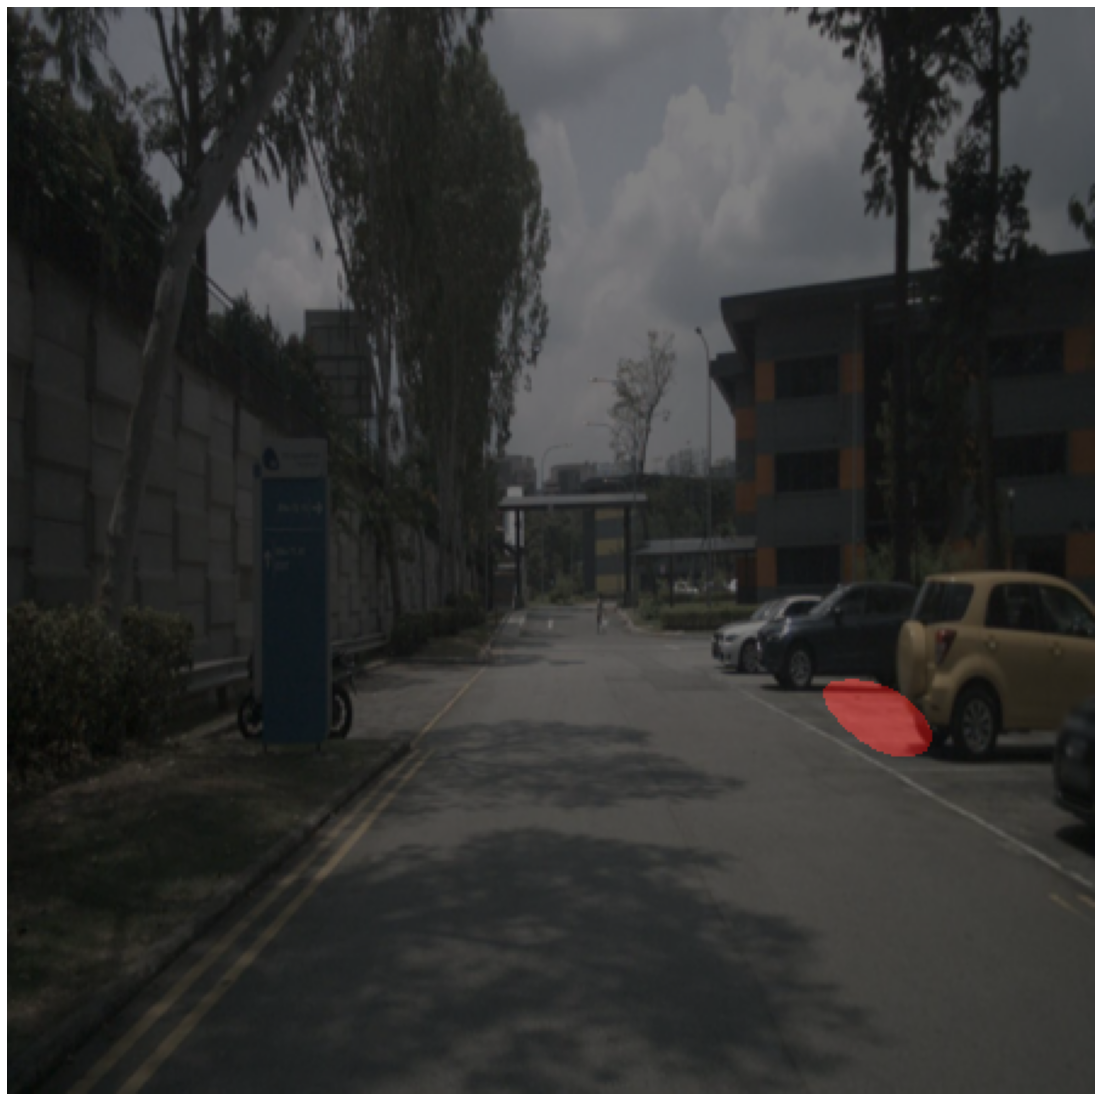

In [61]:
figure = plt.figure(figsize=(20, 20))

plt.imshow(im_seg)
plt.axis('off')
plt.show()

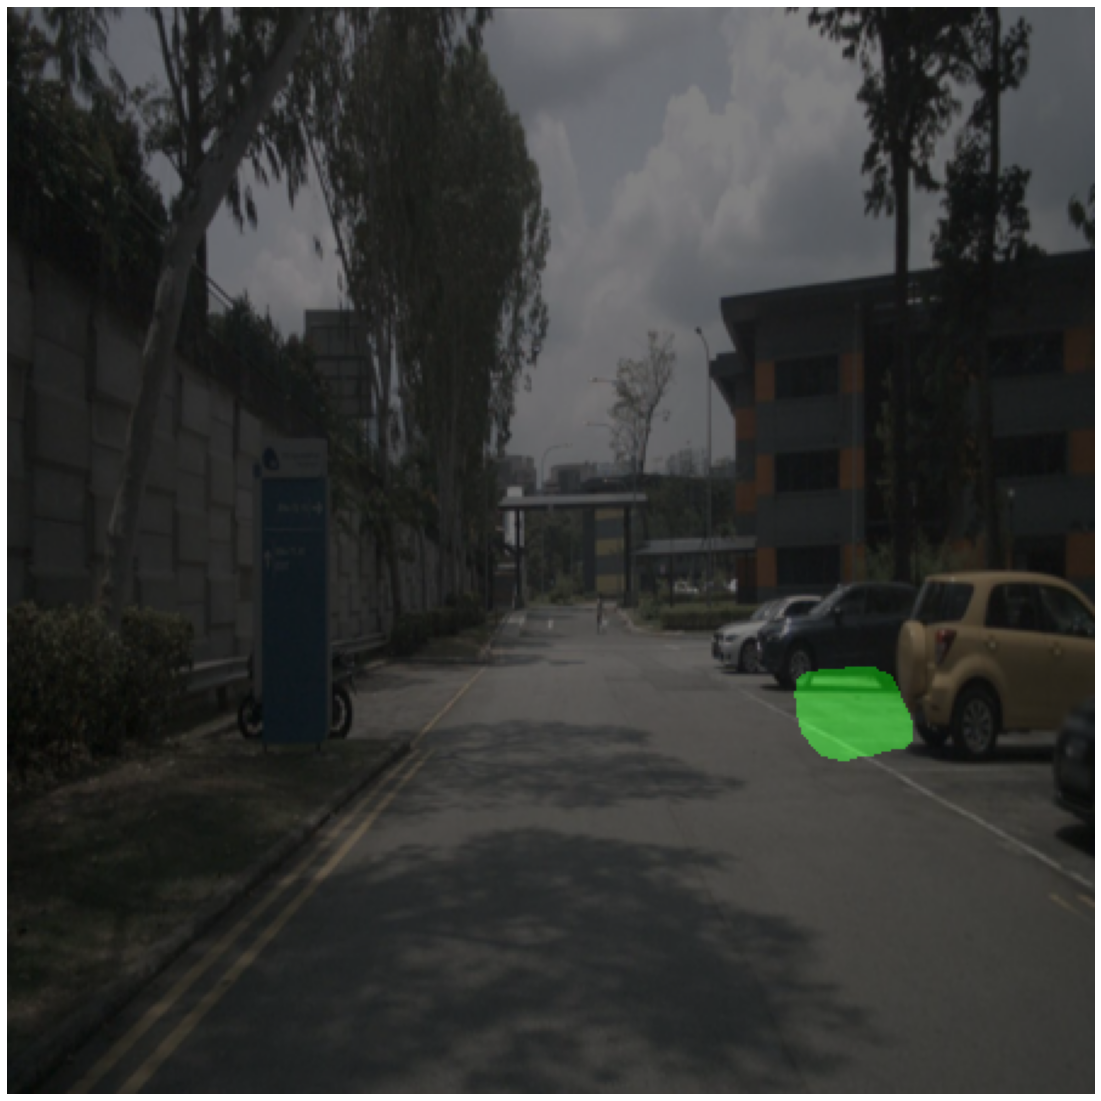

In [56]:
figure = plt.figure(figsize=(20, 20))

plt.imshow(im_gt)
plt.axis('off')
plt.show()

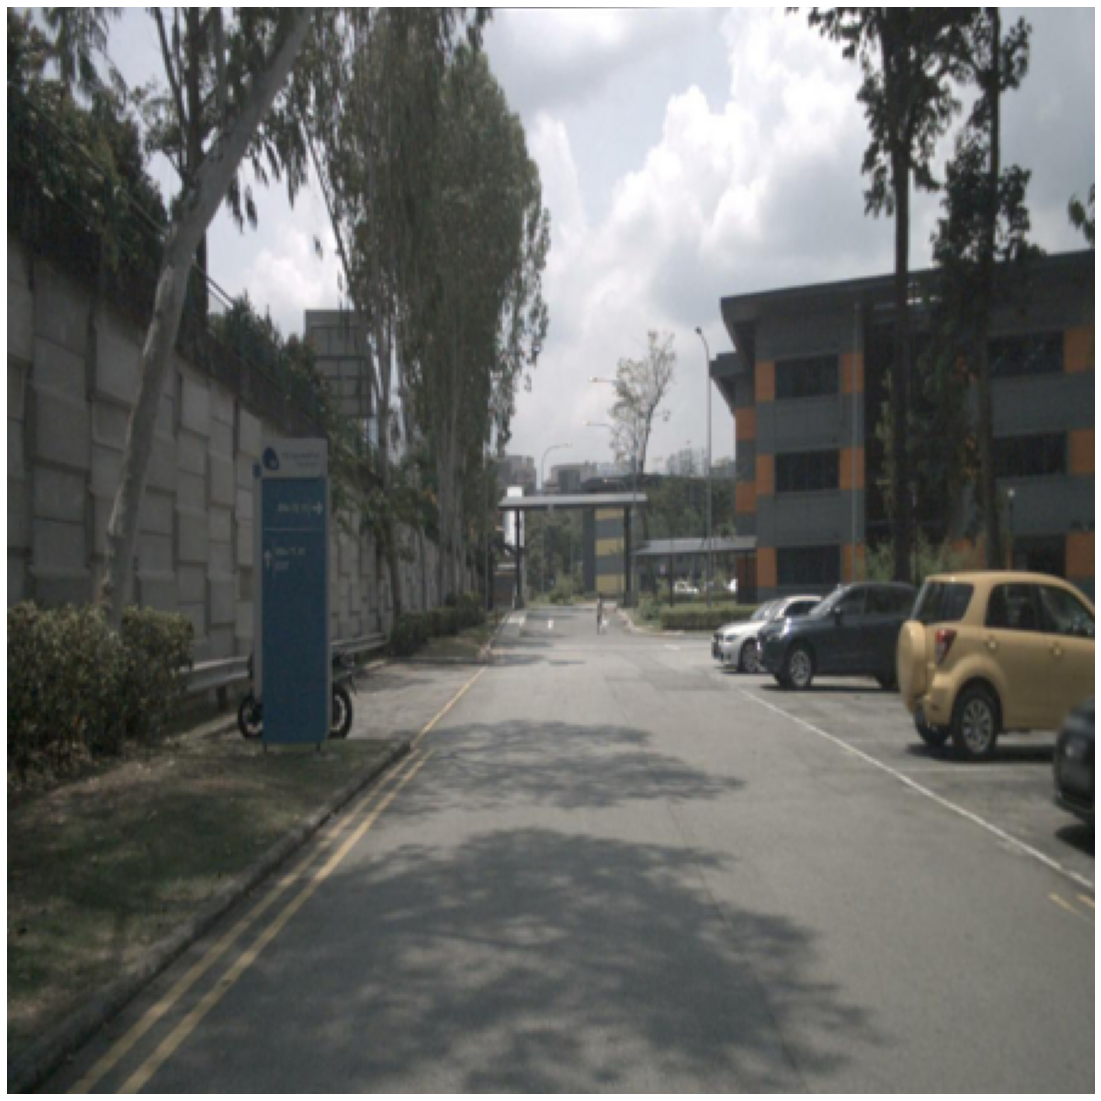

In [63]:
figure = plt.figure(figsize=(20, 20))

plt.imshow(batch['orig_image'])
plt.axis('off')
plt.show()